In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import keras.backend as K
import matplotlib.image as image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from keras.losses import binary_crossentropy
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17048282031378905626
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1735917568
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8354438699067332196
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import os
print(os.listdir('ships'))

['sample_submission_v2.csv', 'test_v2', 'train_ship_segmentations_v2.csv', 'train_v2']


In [5]:
IMG_WIDTH = 768
IMG_HEIGHT = 768
IMG_CHANNELS = 3
TARGET_WIDTH = 128
TARGET_HEIGHT = 128
epochs=2
batch_size=5
image_shape=(768, 768)
FAST_RUN = True 

In [6]:
df = pd.read_csv("ships/train_ship_segmentations_v2.csv")

In [7]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
no_mask = np.zeros(image_shape[0]*image_shape[1], dtype=np.uint8)
def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    return rle

def rle_decode(mask_rle, shape=image_shape):

    if pd.isnull(mask_rle):
        img = no_mask
        return img.reshape(shape).T
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]

    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

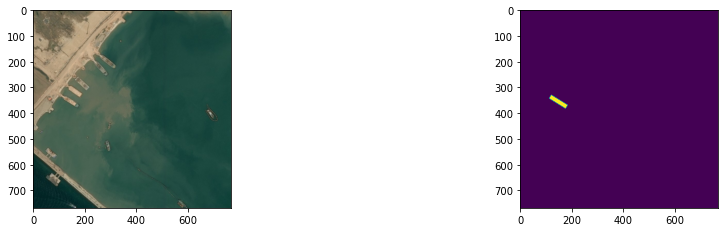

In [8]:
segmentation = df[df.EncodedPixels.notnull()].sample().iloc[0]
image = plt.imread('ships/train_v2/'+segmentation.ImageId)

fig=plt.figure(figsize=(16, 8))
fig.add_subplot(2, 2, 1)
plt.imshow(image)
fig.add_subplot(2, 2, 2)
plt.imshow(rle_decode(segmentation.EncodedPixels))

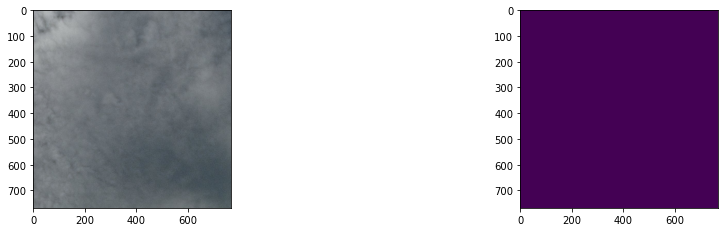

In [9]:
segmentation = df[df.EncodedPixels.isnull()].sample().iloc[0]
image = plt.imread('ships/train_v2/'+segmentation.ImageId)

fig=plt.figure(figsize=(16, 8))
fig.add_subplot(2, 2, 1)
plt.imshow(image)
fig.add_subplot(2, 2, 2)
plt.imshow(rle_decode(segmentation.EncodedPixels))

In [11]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [12]:
inputs = Input((TARGET_WIDTH , TARGET_HEIGHT, IMG_CHANNELS))

# 128

down1 = Conv2D(64, (3, 3), padding='same')(inputs)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1 = Conv2D(64, (3, 3), padding='same')(down1)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
# 64

down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
down2 = BatchNormalization()(down2)
down2 = Activation('relu')(down2)
down2 = Conv2D(128, (3, 3), padding='same')(down2)
down2 = BatchNormalization()(down2)
down2 = Activation('relu')(down2)
down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
# 32

down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
down3 = BatchNormalization()(down3)
down3 = Activation('relu')(down3)
down3 = Conv2D(256, (3, 3), padding='same')(down3)
down3 = BatchNormalization()(down3)
down3 = Activation('relu')(down3)
down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
# 16

down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
down4 = BatchNormalization()(down4)
down4 = Activation('relu')(down4)
down4 = Conv2D(512, (3, 3), padding='same')(down4)
down4 = BatchNormalization()(down4)
down4 = Activation('relu')(down4)
down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
# 8

center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
center = BatchNormalization()(center)
center = Activation('relu')(center)
center = Conv2D(1024, (3, 3), padding='same')(center)
center = BatchNormalization()(center)
center = Activation('relu')(center)
# center

up4 = UpSampling2D((2, 2))(center)
up4 = concatenate([down4, up4], axis=3)
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
# 16

up3 = UpSampling2D((2, 2))(up4)
up3 = concatenate([down3, up3], axis=3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
# 32

up2 = UpSampling2D((2, 2))(up3)
up2 = concatenate([down2, up2], axis=3)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
# 64

up1 = UpSampling2D((2, 2))(up2)
up1 = concatenate([down1, up1], axis=3)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
# 128

outputs = Conv2D(1, (1, 1), activation='sigmoid')(up1)

model = Model(inputs=inputs, outputs=outputs)

In [13]:
model.compile(
    optimizer= tf.keras.optimizers.RMSprop(1e-4), 
    loss='binary_crossentropy', 
    metrics=[dice_coeff]
)

In [21]:
if FAST_RUN:
    df = df.sample(n=10000).reset_index().drop(columns=["index"])

In [15]:
def get_image(image_name):
    img = plt.imread('ships/train_v2/'+image_name)[:,:,:IMG_CHANNELS]
    img = resize(img, (TARGET_WIDTH, TARGET_HEIGHT), mode='constant', preserve_range=True)
    return img
    
def get_mask(code):
    img = rle_decode(code)
    img = resize(img, (TARGET_WIDTH, TARGET_HEIGHT, 1), mode='constant', preserve_range=True)
    return img

def create_image_generator(precess_batch_size, data_df):
    while True:
        for k, group_df in data_df.groupby(np.arange(data_df.shape[0])//precess_batch_size):
            imgs = []
            labels = []
            for index, row in group_df.iterrows():
                # images
                original_img = get_image(row.ImageId) / 255.0
                # masks
                mask = get_mask(row.EncodedPixels) / 255.0
                
                imgs.append(original_img)
                labels.append(mask)
                
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels

In [22]:
train_df, validate_df = train_test_split(df)

train_generator = create_image_generator(batch_size, train_df)
validate_generator = create_image_generator(batch_size, validate_df)

train_steps=np.ceil(float(train_df.shape[0]) / float(batch_size)).astype(int)
validate_steps=np.ceil(float(validate_df.shape[0]) / float(batch_size)).astype(int)

In [23]:
len(train_df)

7500

In [17]:
model.fit(
    train_generator, 
    steps_per_epoch=train_steps,
    validation_data=validate_generator,
    validation_steps=validate_steps,
    epochs=epochs)

Epoch 1/2
7500/7500 [==============================] - 3223s 429ms/step - loss: 0.0074 - dice_coeff: 0.4392 - val_loss: 3.4303e-05 - val_dice_coeff: 0.6900
Epoch 2/2
7500/7500 [==============================] - 3295s 439ms/step - loss: 3.4030e-05 - dice_coeff: 0.6963 - val_loss: 3.4239e-05 - val_dice_coeff: 0.7513


In [19]:
model.save_weights('.ipynb_checkpoints/Mk3-checkpoint101')
